Evaluation Metrics:
Mean Squared Error: 1.67
R-squared: 0.10
Mean Absolute Error: 1.03


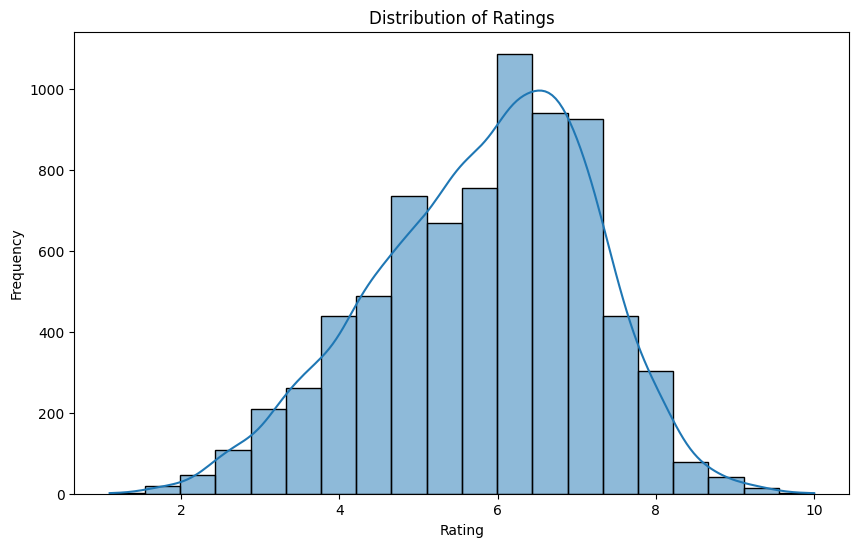

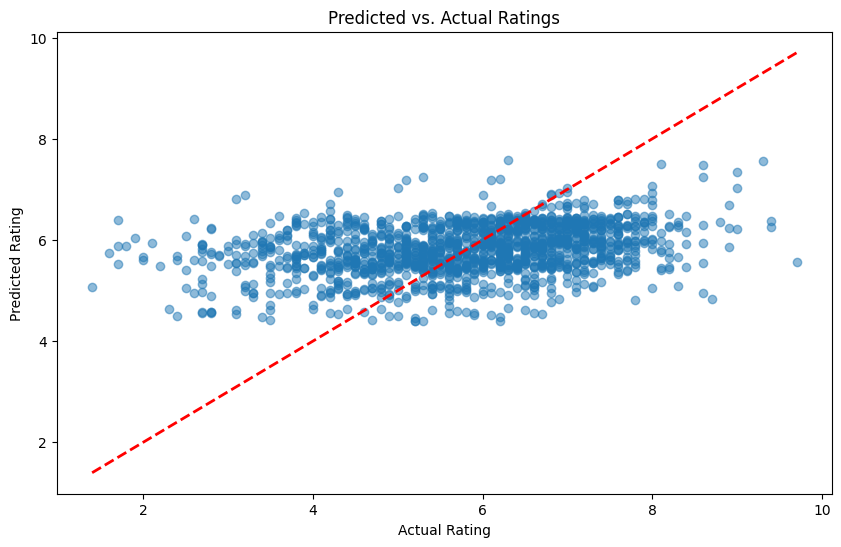

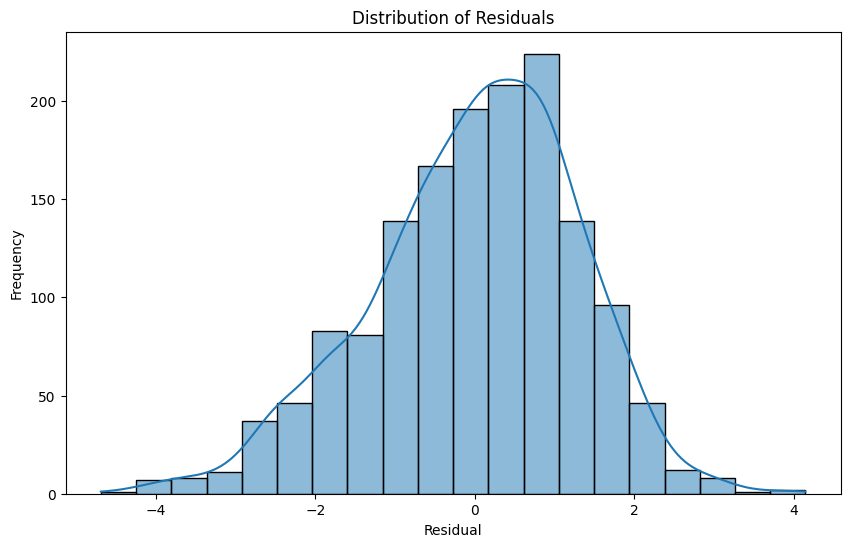

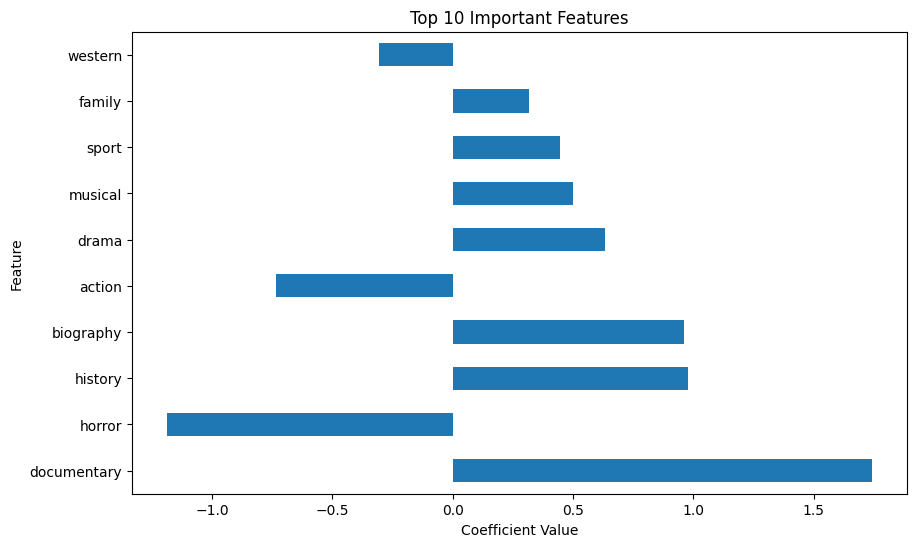

Predicted rating for the new movie: 5.60


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.sparse import issparse

# Load data and handle potential errors
try:
    data = pd.read_csv("/content/drive/MyDrive/IMDb Movies India.csv", encoding='latin-1')
except FileNotFoundError:
    print("Error: File not found at the specified path.")
    exit()
except UnicodeDecodeError:
    print("Error: Invalid encoding specified. Please check the encoding of the CSV file.")
    exit()

# Preprocessing
def preprocess_data(data, vectorizer, director_encoder, actor_encoder):
    """Preprocesses movie data for rating prediction.

    Args:
        data (pandas.DataFrame): The raw movie data.
        vectorizer (TfidfVectorizer): The TF-IDF vectorizer for genre.
        director_encoder (LabelEncoder): The label encoder for directors.
        actor_encoder (LabelEncoder): The label encoder for actors.

    Returns:
        pandas.DataFrame: The preprocessed movie data.
    """

    # Data cleaning
    data.dropna(subset=["Genre", "Director", "Actor 1", "Actor 2", "Actor 3"], inplace=True)
    data["Year"] = data["Year"].str.replace("-", "", regex=True)
    data["Year"] = pd.to_numeric(data["Year"], errors='coerce').fillna(0).astype(int)
    data["Rating"] = data["Rating"].astype(float)

    # Remove rows with NaN values in the "Rating" column
    data.dropna(subset=["Rating"], inplace=True)

    # Text processing for categorical features
    genre_vectorized = vectorizer.fit_transform(data["Genre"])

    # Label encoding for categorical features
    data["Director_encoded"] = director_encoder.fit_transform(data["Director"])
    data["Actor 1_encoded"] = actor_encoder.fit_transform(data["Actor 1"])
    data["Actor 2_encoded"] = actor_encoder.fit_transform(data["Actor 2"])
    data["Actor 3_encoded"] = actor_encoder.fit_transform(data["Actor 3"])

    # Combine genre TF-IDF features with other features
    genre_df = pd.DataFrame(genre_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
    data.reset_index(drop=True, inplace=True)
    data = pd.concat([data, genre_df], axis=1)

    return data, genre_df

# Define the encoders and vectorizer outside the function
vectorizer = TfidfVectorizer(max_features=1000)
director_encoder = LabelEncoder()
actor_encoder = LabelEncoder()

# Preprocess data
data, genre_df = preprocess_data(data.copy(), vectorizer, director_encoder, actor_encoder)  # Avoid modifying original data

# Feature selection
features = list(genre_df.columns) + ["Director_encoded", "Actor 1_encoded", "Actor 2_encoded", "Actor 3_encoded", "Year"]

# Target variable
target = "Rating"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Model building
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluation
print("Evaluation Metrics:")
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

# Visualization: Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.histplot(data["Rating"], bins=20, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# Visualization: Predicted vs. Actual Ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Predicted vs. Actual Ratings")
plt.show()

# Visualization: Residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=20, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Visualization: Feature Importance
coefficients = pd.Series(model.coef_, index=features)
important_features = coefficients.sort_values(key=abs, ascending=False).head(10)

plt.figure(figsize=(10, 6))
important_features.plot(kind='barh')
plt.title("Top 10 Important Features")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

# Function to encode new labels
def encode_new_labels(df, column, encoder):
    """Encode new labels using the existing encoder, adding new labels if necessary.

    Args:
        df (pandas.DataFrame): The data frame containing the column to encode.
        column (str): The column to encode.
        encoder (LabelEncoder): The existing LabelEncoder.

    Returns:
        numpy.ndarray: The encoded labels.
    """
    unique_labels = list(encoder.classes_) + list(df[column].unique())
    encoder.classes_ = np.array(sorted(set(unique_labels)))
    return encoder.transform(df[column])

# Prediction (example for a new movie)
new_movie = {
    "Genre": "Comedy|Romance",  # Example genre (modify as needed)
    "Director": "New Director",  # Example director (modify as needed)
    "Actor 1": "New Actor 1",  # Example actor (modify as needed)
    "Actor 2": "New Actor 2",  # Example actor (modify as needed)
    "Actor 3": "New Actor 3",  # Example actor (modify as needed)
    "Year": 2024
}

# Preprocess new movie data
new_movie_df = pd.DataFrame([new_movie])
new_movie_df["Director_encoded"] = encode_new_labels(new_movie_df, "Director", director_encoder)
new_movie_df["Actor 1_encoded"] = encode_new_labels(new_movie_df, "Actor 1", actor_encoder)
new_movie_df["Actor 2_encoded"] = encode_new_labels(new_movie_df, "Actor 2", actor_encoder)
new_movie_df["Actor 3_encoded"] = encode_new_labels(new_movie_df, "Actor 3", actor_encoder)
new_movie_genre_vectorized = vectorizer.transform(new_movie_df["Genre"])
new_movie_genre_df = pd.DataFrame(new_movie_genre_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
new_movie_df = pd.concat([new_movie_df, new_movie_genre_df], axis=1)

# Ensure new_movie_df has all required features
missing_cols = set(features) - set(new_movie_df.columns)
for col in missing_cols:
    new_movie_df[col] = 0

# Predict rating
new_movie_rating = model.predict(new_movie_df[features])[0]

print(f"Predicted rating for the new movie: {new_movie_rating:.2f}")
